In [1]:
import numpy as np
import pandas as pd
from opt_utils import *
from grad_utils import *
import matplotlib.pyplot as plt
%matplotlib inline

### Download and Load the Raw Races Dataset

In [2]:
url = "http://personal.psu.edu/drh20/code/btmatlab/nascar2002.txt"
races_trimmed = pd.read_table(url, sep=" ")

### Create the Complete Dataset

- Most drivers do not race all of the races, 
- We need to create a dataset with every combination of all drivers/ races so that we can take pairwise differences consistently

In [3]:
# Create a cartesian product of unique drivers and races to get every combination
unq_drivers = sorted(races_trimmed["DriverID"].unique())
unq_drivers = [x for x in unq_drivers if str(x) != 'nan']
unq_races = sorted(races_trimmed["Race"].unique())
unq_races = [x for x in unq_races if str(x) != 'nan']

# Get a dataframe 
unq_drivers_df = pd.DataFrame(unq_drivers, columns=["DriverID"])
unq_races_df = pd.DataFrame(unq_races, columns=["Race"])

# Let's cross join the columns to get all unique combinations of drivers and races
all_driver_race_combs = unq_drivers_df.assign(foo=1).merge(unq_races_df.assign(foo=1)).drop('foo', 1)
all_driver_race_combs = all_driver_race_combs.sort_values(by=['Race', 'DriverID'])
all_driver_race_mg = pd.merge(all_driver_race_combs, races_trimmed,  how='left', 
                              left_on=['DriverID','Race'], right_on = ['DriverID','Race'])

### For a single race calculate the pairwise differences

In [4]:
def pawise_ind(val):
    if np.isnan(val):
        out = val
    else:
        out = (val < 0) * 1
    return out

def difference_matrix(a):
    """ Get the pairwise differences in all quantities in a 1D-numpy array
    Source: https://stackoverflow.com/questions/22863547/numpy-compute-all-possible-differences-in-an-array-at-fixed-distance"""
    x = np.reshape(a, (len(a), 1))
    return x - x.T

def get_single_race_pwise(race_num, src_dat):
    """Get all pairwise race comparisons for a single race"""
    
    race_res = all_driver_race_mg[all_driver_race_mg["Race"] == race_num]
    race_res = race_res.sort_values(by=['DriverID'])
    race_res_val = race_res.values[:, 2]
    
    vpawise_ind = np.vectorize(pawise_ind)
    pwise_diff = difference_matrix(race_res_val)
    #pwise_diff = vpawise_ind(pwise_diff)
    
    return pwise_diff

def get_all_pwise_comb(src_dat):
    unq_races = sorted(src_dat["Race"].unique())
    all_pwise_races = [get_single_race_pwise(race_num=race, src_dat=src_dat) for race in unq_races]
    return np.dstack(all_pwise_races)

## Get pairwise differences for all Drivers for a single race

In [5]:
race_16_diffs = get_single_race_pwise(race_num=16.0, src_dat=all_driver_race_mg)
race_16_diffs.shape

(83, 83)

## Get pairwise differences for all competitors and all races

In [6]:
all_pwise = get_all_pwise_comb(src_dat=all_driver_race_mg)
all_pwise.shape

(83, 83, 36)

In [7]:
all_pwise[1]

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [-21.,   2., -35., ...,   1.,   1.,  -3.],
       ...,
       [ nan,  nan,  nan, ...,  nan, -13.,  nan],
       [-32.,   7.,   3., ...,  25.,  22., -11.],
       [ 10.,  -2., -13., ...,  -1.,  11.,  -5.]])

In [8]:
all_pwise.shape

(83, 83, 36)

In [9]:
game_matrix_list = []
for i in range(all_pwise.shape[2]):
    pwise_diff = all_pwise[:,:,i]
    pwise_diff[pwise_diff <= 0] = 1
    pwise_diff[pwise_diff < 0] = 0
    pwise_diff[np.isnan(pwise_diff)] = 0
    game_matrix_list.append(pwise_diff)
game_matrix_list = np.array(game_matrix_list)

c:\python\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.
c:\python\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [9]:
game_matrix_list.shape

(36, 83, 83)

## Fit the model with squared l2-penalty

### Fit with small penalty

In [10]:
# optimization parameters
l_penalty = 20
max_iter = 1000
ths = 1e-12
step_size = 0.03

# backtracking parameters
step_init = 0.1
max_back = 100
a = 0.2
b = 0.5

### Fit with large penalty

In [26]:
# optimization parameters
l_penalty = 200
max_iter = 1000
ths = 1e-12
step_size = 0.03

# backtracking parameters
step_init = 0.1
max_back = 100
a = 0.2
b = 0.5

### Newton

In [27]:
data = game_matrix_list

# intiialize optimization
T, N = data.shape[0:2]
beta = np.zeros(data.shape[:2]).reshape((N * T,1))
step_size = 1

# initialize record
objective_nt = [objective_l2_sq(beta, data, l_penalty)]
print("initial objective value: %f"%objective_nt[-1])

# iteration
for i in range(max_iter):
    # compute gradient
    gradient = grad_l2_sq(beta, data, l_penalty)[1:]
    hessian = hess_l2_sq(beta, data, l_penalty)[1:,1:]
    
    # newton update
    beta[1:] = beta[1:] - step_size * sc.linalg.solve(hessian, gradient)
    
    # objective value
    objective_nt.append(objective_l2_sq(beta, data, l_penalty))
    
    print("%d-th Newton, objective value: %f"%(i+1, objective_nt[-1]))
    if objective_nt[-2] - objective_nt[-1] < ths:
        print("Converged!")
        break
        
if i >= max_iter:
    print("Not converged.")

initial objective value: 351878.245653
1-th Newton, objective value: 231368.343357
2-th Newton, objective value: 224645.572981
3-th Newton, objective value: 224279.641909
4-th Newton, objective value: 224273.855933
5-th Newton, objective value: 224273.848497
6-th Newton, objective value: 224273.848496
7-th Newton, objective value: 224273.848496
Converged!


In [14]:
?np.argsort

In [28]:
beta = beta.reshape((T,N))

# ascending order
rank = np.argsort(-beta[-1,])

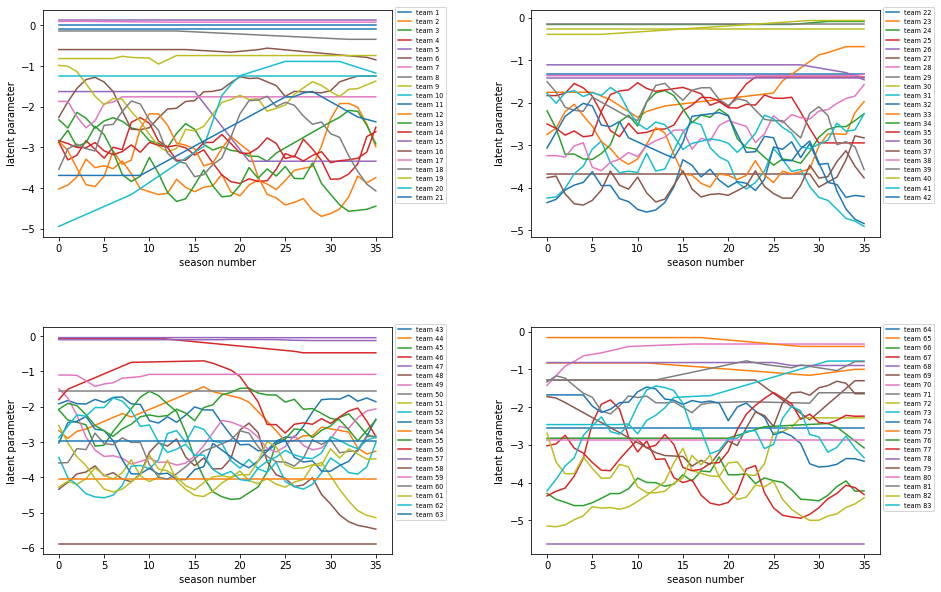

In [29]:
n_group = 4
group_id = np.array_split(range(N), n_group)
fig = plt.figure(figsize = (15,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for g in range(n_group):
    ax = fig.add_subplot(2, 2, g + 1)
    for i in group_id[g]:
        ax.plot(beta[:,i], label="team %d"%(i + 1))
    plt.xlabel("season number")
    plt.ylabel("latent parameter")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1.03, 1, 0),prop={'size': 6.5},ncol = 1)


## L1 penalty

In [28]:
from opt_utils import *
from grad_utils import *
from numpy.linalg import solve

In [50]:
def admm_sub_beta(T,N,A,lam,eta,betak,muk,thetak,paras):
    step_size, ths, max_iter = paras
    obj_old = np.inf
    for i in range(max_iter):    
        # compute gradient
        gradient = grad_nl(betak, data) + A.T @ muk + eta * A.T @ (A @ betak - thetak)
        hessian = hess_nl(betak, data) + eta * A.T @ A
        gradient = gradient[1:]
        hessian = hessian[1:,1:]
        # Newton update
        betak[1:] = betak[1:] - step_size * solve(hessian, gradient)

        obj_new = neg_log_like(betak, data) + (A @ betak).T @ muk + eta / 2 * np.linalg.norm(A @ betak - thetak) ** 2
        if obj_old - obj_new < ths:
            break
        obj_old = obj_new
    if i >= max_iter - 1:
        print("Sub-opt for beta not converged.")
    
    return betak

def prox_l1(t,x):
    return np.sign(x) * np.max(np.array([x * 0, np.abs(x) - t]),axis = 0)

In [20]:
hh = admm_sub_beta(T,N,A,l_penalty,eta,betak,muk,thetak,paras,ths = ths_sub)

KeyboardInterrupt: 

In [42]:
import cProfile
cProfile.run('hh = admm_sub_beta(T,N,A,l_penalty,eta,betak,muk,thetak,paras = paras_sub)')

0
1
2
3
4
5
6
7
8
9
         43914 function calls (42104 primitive calls) in 9.070 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       30    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(copyto)
      360    0.000    0.000    0.004    0.000 <__array_function__ internals>:2(diag)
       10    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(dot)
       10    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(norm)
       10    0.000    0.000    2.725    0.273 <__array_function__ internals>:2(solve)
      720    0.000    0.000    0.023    0.000 <__array_function__ internals>:2(tril)
     1080    0.001    0.000    0.037    0.000 <__array_function__ internals>:2(triu)
     1800    0.001    0.000    0.022    0.000 <__array_function__ internals>:2(where)
        1    5.503    5.503    9.057    9.057 <ipython-input-33-3369e13814ca>:1(admm_sub_beta)
        1    0.013    0.013 

In [52]:
data = game_matrix_list
# intiialize optimization
T, N = data.shape[0:2]

# optimization parameters
l_penalty = 10
max_iter = 1000
max_iter_sub = 100
ths = 1e-13
ths_sub = 1e-8
eta = 500
step_size = 0.03
step_size_sub = 0.1

paras = [step_size, ths, max_iter]
paras_sub = [step_size_sub, ths_sub, max_iter_sub]

In [53]:

betak = np.zeros((T * N,1))
thetak = np.zeros(((T - 1) * N,1))


A = np.zeros(((T - 1) * N, T * N))
for i in range(N):
    for t in range(T-1):
        A[t * N + i, (t + 1) * N + i] = 1
        A[t * N + i, (t) * N + i] = -1


muk = A @ betak - thetak

# initialize record
objective_admm_b = [objective_l1(betak, data, l_penalty)]
objective_admm = [neg_log_like(betak, data) + l_penalty * np.linalg.norm(thetak,1)]
print("initial objective value: %f"%objective_admm[-1])

# iteration
for i in range(max_iter):
    # compute gradient
    betak = admm_sub_beta(T,N,A,l_penalty,eta,betak,muk,thetak,paras = paras_sub)
    thetak = prox_l1(l_penalty / eta,A @ betak + muk / eta)
    muk = muk + eta * (A @ betak - thetak)
    # objective value
    objective_admm_b.append(objective_l1(betak, data, l_penalty))
    objective_admm.append(neg_log_like(betak, data) + l_penalty * np.linalg.norm(thetak,1))
    
    print("%d-th ADMM, objective value: %f"%(i+1, objective_admm[-1]))
    if abs(objective_admm[-2] - objective_admm[-1]) < ths:
        print("Converged!")
        break
#     print("%d-th ADMM, objective value: %f"%(i+1, objective_admm_b[-1]))
#     if objective_admm_b[-2] - objective_admm_b[-1] < ths:
#         print("Converged!")
#         break
        
if i >= max_iter:
    print("Not converged.")

initial objective value: 351878.245653
Sub-opt for beta not converged.
1-th ADMM, objective value: 212198.777614
Sub-opt for beta not converged.
2-th ADMM, objective value: 195525.961349
Sub-opt for beta not converged.
3-th ADMM, objective value: 184360.990710
Sub-opt for beta not converged.
4-th ADMM, objective value: 176725.395330
Sub-opt for beta not converged.
5-th ADMM, objective value: 171109.411276
Sub-opt for beta not converged.
6-th ADMM, objective value: 166801.955631
Sub-opt for beta not converged.
7-th ADMM, objective value: 163392.977396
Sub-opt for beta not converged.
8-th ADMM, objective value: 160636.009619
Sub-opt for beta not converged.
9-th ADMM, objective value: 158375.627710
Sub-opt for beta not converged.
10-th ADMM, objective value: 156491.941226
Sub-opt for beta not converged.
11-th ADMM, objective value: 154899.480355
Sub-opt for beta not converged.
12-th ADMM, objective value: 153545.016734
Sub-opt for beta not converged.
13-th ADMM, objective value: 152385.70

163-th ADMM, objective value: 142691.390455
164-th ADMM, objective value: 142691.216523
165-th ADMM, objective value: 142691.046559
166-th ADMM, objective value: 142690.880375
167-th ADMM, objective value: 142690.717869
168-th ADMM, objective value: 142690.558938
169-th ADMM, objective value: 142690.403470
170-th ADMM, objective value: 142690.255219
171-th ADMM, objective value: 142690.105715
172-th ADMM, objective value: 142689.957985
173-th ADMM, objective value: 142689.815406
174-th ADMM, objective value: 142689.675976
175-th ADMM, objective value: 142689.539551
176-th ADMM, objective value: 142689.406046
177-th ADMM, objective value: 142689.274925
178-th ADMM, objective value: 142689.147553
179-th ADMM, objective value: 142689.028163
180-th ADMM, objective value: 142688.904415
181-th ADMM, objective value: 142688.781720
182-th ADMM, objective value: 142688.661176
183-th ADMM, objective value: 142688.544654
184-th ADMM, objective value: 142688.432637
185-th ADMM, objective value: 14

350-th ADMM, objective value: 142681.548033
351-th ADMM, objective value: 142681.533428
352-th ADMM, objective value: 142681.518944
353-th ADMM, objective value: 142681.504579
354-th ADMM, objective value: 142681.490331
355-th ADMM, objective value: 142681.476200
356-th ADMM, objective value: 142681.462183
357-th ADMM, objective value: 142681.448284
358-th ADMM, objective value: 142681.434537
359-th ADMM, objective value: 142681.420861
360-th ADMM, objective value: 142681.407295
361-th ADMM, objective value: 142681.393839
362-th ADMM, objective value: 142681.380490
363-th ADMM, objective value: 142681.367247
364-th ADMM, objective value: 142681.354110
365-th ADMM, objective value: 142681.341077
366-th ADMM, objective value: 142681.328147
367-th ADMM, objective value: 142681.315319
368-th ADMM, objective value: 142681.302592
369-th ADMM, objective value: 142681.289965
370-th ADMM, objective value: 142681.277436
371-th ADMM, objective value: 142681.265005
372-th ADMM, objective value: 14

537-th ADMM, objective value: 142680.126779
538-th ADMM, objective value: 142680.123466
539-th ADMM, objective value: 142680.120178
540-th ADMM, objective value: 142680.116914
541-th ADMM, objective value: 142680.113675
542-th ADMM, objective value: 142680.110461
543-th ADMM, objective value: 142680.107270
544-th ADMM, objective value: 142680.104105
545-th ADMM, objective value: 142680.100964
546-th ADMM, objective value: 142680.097847
547-th ADMM, objective value: 142680.094752
548-th ADMM, objective value: 142680.091681
549-th ADMM, objective value: 142680.088633
550-th ADMM, objective value: 142680.085608
551-th ADMM, objective value: 142680.082605
552-th ADMM, objective value: 142680.079625
553-th ADMM, objective value: 142680.076667
554-th ADMM, objective value: 142680.073731
555-th ADMM, objective value: 142680.070817
556-th ADMM, objective value: 142680.067924
557-th ADMM, objective value: 142680.065054
558-th ADMM, objective value: 142680.062204
559-th ADMM, objective value: 14

724-th ADMM, objective value: 142679.795662
725-th ADMM, objective value: 142679.794916
726-th ADMM, objective value: 142679.794176
727-th ADMM, objective value: 142679.793443
728-th ADMM, objective value: 142679.792716
729-th ADMM, objective value: 142679.791994
730-th ADMM, objective value: 142679.791280
731-th ADMM, objective value: 142679.790572
732-th ADMM, objective value: 142679.789869
733-th ADMM, objective value: 142679.789172
734-th ADMM, objective value: 142679.788481
735-th ADMM, objective value: 142679.787796
736-th ADMM, objective value: 142679.787117
737-th ADMM, objective value: 142679.786443
738-th ADMM, objective value: 142679.785775
739-th ADMM, objective value: 142679.785113
740-th ADMM, objective value: 142679.784456
741-th ADMM, objective value: 142679.783804
742-th ADMM, objective value: 142679.783158
743-th ADMM, objective value: 142679.782517
744-th ADMM, objective value: 142679.781882
745-th ADMM, objective value: 142679.781252
746-th ADMM, objective value: 14

911-th ADMM, objective value: 142679.724793
912-th ADMM, objective value: 142679.724634
913-th ADMM, objective value: 142679.724477
914-th ADMM, objective value: 142679.724321
915-th ADMM, objective value: 142679.724167
916-th ADMM, objective value: 142679.724013
917-th ADMM, objective value: 142679.723861
918-th ADMM, objective value: 142679.723710
919-th ADMM, objective value: 142679.723560
920-th ADMM, objective value: 142679.723412
921-th ADMM, objective value: 142679.723264
922-th ADMM, objective value: 142679.723118
923-th ADMM, objective value: 142679.722973
924-th ADMM, objective value: 142679.722829
925-th ADMM, objective value: 142679.722687
926-th ADMM, objective value: 142679.722545
927-th ADMM, objective value: 142679.722405
928-th ADMM, objective value: 142679.722265
929-th ADMM, objective value: 142679.722127
930-th ADMM, objective value: 142679.721990
931-th ADMM, objective value: 142679.721854
932-th ADMM, objective value: 142679.721719
933-th ADMM, objective value: 14

In [18]:
i

[351878.24565279804, 190352.2372746421]

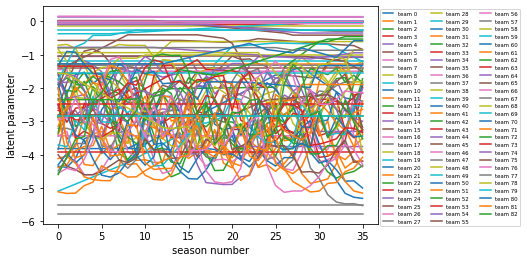

In [16]:
beta = betak
beta = beta.reshape((T,N))
for i in range(N):
    plt.plot(beta[:,i], label="team %d"%i)
plt.xlabel("season number")
plt.ylabel("latent parameter")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1, 1, 0),prop={'size': 5.4},ncol = 3)

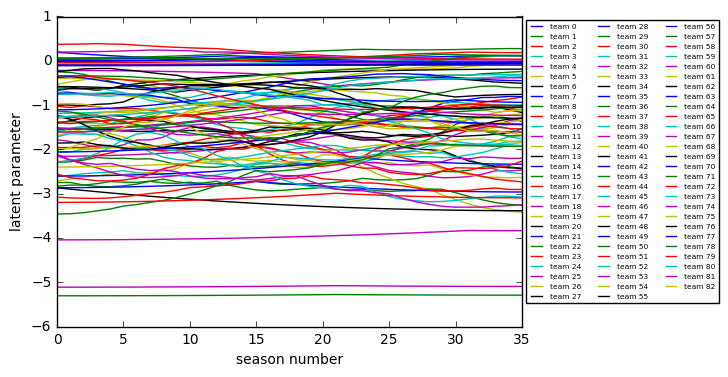

In [52]:
beta = beta.reshape((T,N))
for i in range(N):
    plt.plot(beta[:,i], label="team %d"%i)
plt.xlabel("season number")
plt.ylabel("latent parameter")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1, 1, 0),prop={'size': 5.4},ncol = 3)